In [1]:
# import sys
# sys.path.append("..")

import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
# from optical_bloch.utils.general import flatten
# from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

# System setup: 3+3 system

In [2]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

ν = 1
Γ = 1

# ν = 431.27*1E12
# Gamma = 1/(33E-9)

# Re = np.sqrt(1/q_e**2 * 3*np.pi*eps_0*hbar*c**3/(2*np.pi*ν)**3 * Gamma)
# print('for A state Re is',Re/a0, Re)
# print(Re * q_e / (3.33564E-30))

# ν = 472.03E12
# Gamma = 1/(58E-9)

# Re = np.sqrt(1/q_e**2 * 3*np.pi*eps_0*hbar*c**3/(2*np.pi*ν)**3 * Gamma)
# print('for B state Re is',Re/a0, Re)
# print(Re * q_e / (3.33564E-30))

In [3]:
nground = 3#12
nexcite = 3#4
ntotal = 6#16

rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix33toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix33toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix33toy3.csv',delimiter=',')

# rabi_matrix[:,:,0] = np.genfromtxt('rabimatrixXA1.csv',delimiter=',')
# rabi_matrix[:,:,1] = np.genfromtxt('rabimatrixXA2.csv',delimiter=',')
# rabi_matrix[:,:,2] = np.genfromtxt('rabimatrixXA3.csv',delimiter=',')

In [4]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)

ge = Symbol(u'ge', real = True)
gg = Symbol(u'gg', real = True)

# ϕ = Symbol(u'ϕ', real = True)
# θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)

# Coskzm = Symbol(u'Coskzm', real = True)
# Coskzp = Symbol(u'Coskzp', real = True)

Coskz = Symbol(u'Coskz', real = True)
Sinkz = Symbol(u'Sinkz', real = True)

# HFS12 = Symbol(u'HFS12', real = True)
# HFS32 = Symbol(u'HFS32', real = True)
# SR = Symbol(u'SR', real = True)
# HFSB = Symbol(u'HFSB', real = True)

# ω1 = Symbol(u'ω1', real = True)
# ω2 = Symbol(u'ω2', real = True)
# ω3 = Symbol(u'ω3', real = True)
# ω4 = Symbol(u'ω4', real = True)
# Ω1 = Symbol(u'Ω1', real = True)
# Ω2 = Symbol(u'Ω2', real = True)
# Ω3 = Symbol(u'Ω3', real = True)
# Ω4 = Symbol(u'Ω4', real = True)
# Δ1 = Symbol(u'Δ1', real = True)
# Δ2 = Symbol(u'Δ2', real = True)
# Δ3 = Symbol(u'Δ3', real = True)
# Δ4 = Symbol(u'Δ4', real = True)


# g_x12F1 = Symbol(u'g_x12F1', real = True)
# g_x32F1 = Symbol(u'g_x32F1', real = True)
# g_x32F2 = Symbol(u'g_x32F2', real = True)


In [5]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-gg*B, E0, E0+gg*B, Ee-ge*B, Ee, Ee+ge*B])

# States are added in following order:
# XSigma %1-4 - J=1/2, F=0, m=0;  F=1, m=-1,0,1 ;
# XSigma %5-7 - J=3/2, F=1, m=-1,0,1;
# XSigma %8-12 - J=3/2, F=2, m=-2,-1,0,1,2;
# BSigma %13-16 - J=1/2, F=0, m=0;  F=1, m=-1,0,1

# ham = Hamiltonian(ntotal)
# ham.addEnergies([E0,E0-HFS12-g_x12F1*B,E0-HFS12,E0-HFS12+g_x12F1*B,
#                  E0+SR-g_x32F1*B,E0+SR,E0+SR+g_x32F1*B,
#                  E0+SR+HFS32-2*g_x32F2*B,E0+SR+HFS32-g_x32F2*B,E0+SR+HFS32,E0+SR+HFS32+g_x32F2*B,E0+SR+HFS32+2*g_x32F2*B,
#                  Ee,Ee+HFSB,Ee+HFSB,Ee+HFSB])

In [6]:
for i in [0,1,2]:
    for j in [3,4,5]:
        if rabi_matrix[i, j, 0] != 0:
            prefactor = Sinkz-1j*Coskz
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = -Sinkz-1j*Coskz
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

# for i in [0]:
#     for j in range(nground, ntotal):
#         if rabi_matrix[i, j, 0] != 0:
#             prefactor = (-1)/np.sqrt(2)*sin(θ*t)
#             ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,0], ω1)
#         if rabi_matrix[i, j, 1] != 0:
#             prefactor = (1)*cos(θ)
#             ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,1], ω1)
#         if rabi_matrix[i, j, 2] != 0:
#             prefactor = (1)/np.sqrt(2)*sin(θ)
#             ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,2], ω1)
            
# for i in [1,2,3]:
#     for j in range(nground, ntotal):
#         if rabi_matrix[i, j, 0] != 0:
#             prefactor = (-1)/np.sqrt(2)*sin(θ)
#             ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,0], ω2)
#         if rabi_matrix[i, j, 1] != 0:
#             prefactor = (1)*cos(θ)
#             ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,1], ω2)
#         if rabi_matrix[i, j, 2] != 0:
#             prefactor = (1)/np.sqrt(2)*sin(θ)
#             ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,2], ω2)
            
# for i in [4,5,6]:
#     for j in range(nground, ntotal):
#         if rabi_matrix[i, j, 0] != 0:
#             prefactor = (-1)/np.sqrt(2)*sin(θ)
#             ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,0], ω3)
#         if rabi_matrix[i, j, 1] != 0:
#             prefactor = (1)*cos(θ)
#             ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,1], ω3)
#         if rabi_matrix[i, j, 2] != 0:
#             prefactor = (1)/np.sqrt(2)*sin(θ)
#             ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,2], ω3)
            
# for i in [7,8,9,10,11]:
#     for j in range(nground, ntotal):
#         if rabi_matrix[i, j, 0] != 0:
#             prefactor = (-1)/np.sqrt(2)*sin(θ)
#             ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,0], ω4)
#         if rabi_matrix[i, j, 1] != 0:
#             prefacccccccctor = (1)*cos(θ)
#             ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,1], ω4)
#         if rabi_matrix[i, j, 2] != 0:
#             prefactor = (1)/np.sqrt(2)*sin(θ)
#             ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,2], ω4)

In [7]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)

# ham.eqnTransform()
# ham.defineZero(Ee)
# ham.defineEnergyDetuning(E0, Ee, Δ1, ω1)
# ham.defineEnergyDetuning(E0-HFS12, Ee, Δ2, ω2)
# ham.defineEnergyDetuning(E0+SR, Ee, Δ3, ω3)
# ham.defineEnergyDetuning(E0+SR+HFS32, Ee, Δ4, ω4)

In [8]:
ham.transformed

Matrix([
[                         -B*gg - 1.0*Δ,                                      0,                                     0,                                      0,  0.166666666666666*Ω*(I*Coskz + Sinkz),                                     0],
[                                     0,                                 -1.0*Δ,                                     0, 0.166666666666666*Ω*(-I*Coskz + Sinkz),                                      0, 0.166666666666666*Ω*(I*Coskz + Sinkz)],
[                                     0,                                      0,                          B*gg - 1.0*Δ,                                      0, 0.166666666666666*Ω*(-I*Coskz + Sinkz),                                     0],
[                                     0,  0.166666666666666*Ω*(I*Coskz + Sinkz),                                     0,                                  -B*ge,                                      0,                                     0],
[0.166666666666666*Ω*(-I*Coskz 

In [9]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2
            
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [10]:
BR[nground:,:]

array([[0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. ]])

In [11]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.33it/s]


In [12]:
dis.dissipator

Matrix([
[ 0.5*Γ*(ρ₃₃(t) + ρ₄₄(t)),                        0,                        0,            -0.5*Γ*ρ₀₃(t),            -0.5*Γ*ρ₀₄(t), -0.5*Γ*ρ₀₅(t)],
[                       0,  0.5*Γ*(ρ₃₃(t) + ρ₅₅(t)),                        0,            -0.5*Γ*ρ₁₃(t),            -0.5*Γ*ρ₁₄(t), -0.5*Γ*ρ₁₅(t)],
[                       0,                        0,  0.5*Γ*(ρ₄₄(t) + ρ₅₅(t)),            -0.5*Γ*ρ₂₃(t),            -0.5*Γ*ρ₂₄(t), -0.5*Γ*ρ₂₅(t)],
[-0.5*Γ*conjugate(ρ₀₃(t)), -0.5*Γ*conjugate(ρ₁₃(t)), -0.5*Γ*conjugate(ρ₂₃(t)),            -1.0*Γ*ρ₃₃(t),            -1.0*Γ*ρ₃₄(t), -1.0*Γ*ρ₃₅(t)],
[-0.5*Γ*conjugate(ρ₀₄(t)), -0.5*Γ*conjugate(ρ₁₄(t)), -0.5*Γ*conjugate(ρ₂₄(t)), -1.0*Γ*conjugate(ρ₃₄(t)),            -1.0*Γ*ρ₄₄(t), -1.0*Γ*ρ₄₅(t)],
[-0.5*Γ*conjugate(ρ₀₅(t)), -0.5*Γ*conjugate(ρ₁₅(t)), -0.5*Γ*conjugate(ρ₂₅(t)), -1.0*Γ*conjugate(ρ₃₅(t)), -1.0*Γ*conjugate(ρ₄₅(t)), -1.0*Γ*ρ₅₅(t)]])

In [13]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 509 ms


In [14]:
y0 = np.zeros([ntotal, ntotal], dtype = complex)
for i in range(nground):
    y0[i,i] = 1/nground
y0 = y0.flatten()

In [15]:
# Γ_val = 1
# Δgroup = -2E-3
# Ω1_val = 3*Γ_val
# Ω2_val = 3*Γ_val
# Ω3_val = 3*Γ_val
# Ω4_val = 3*Γ_val
# replacements = [(B, 1),
#                 (HFSB, 3E-3),
#                 (g_x12F1, -0.33*Bohr_mag),
#                 (g_x32F1, 0.83*Bohr_mag),
#                 (g_x32F2, 0.5*Bohr_mag),
#                 (Δ1, Δgroup),
#                 (Δ2, Δgroup),
#                 (Δ3, Δgroup),
#                 (Δ4, Δgroup),
#                 (Ω1, Ω1_val),
#                 (Ω2, Ω2_val),
#                 (Ω3, Ω3_val),
#                 (Ω4, Ω4_val),
#                 (θ, 60/180*np.pi),
#                 (Γ, Γ_val)]

In [16]:
# %%time
# sol = bloch.solveNumeric(replacements, [0,1000], y0, method = 'BDF')

In [17]:
# r = np.einsum("iij->ij", sol.y.reshape(ntotal,ntotal,sol.t.size)).real

# fig, ax = plt.subplots(figsize = (8,5))
# for idx in range(ntotal):
#     ax.plot(sol.t, r[idx], label = f"ρ$_{{{idx},{idx}}}$", lw = 2)

# ax.legend(fontsize = 13)
# ax.set_xlabel('time')
# ax.set_ylabel('population')

# set_fontsize(ax, 14)

In [18]:
from julia import Main

nprocs = 6 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [19]:
# Time_varying_symbols = 'Coskzm Coskzp'.split(' ')
Time_varying_symbols = 'Coskz Sinkz'.split(' ')

In [20]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = [d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']]

lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex, k, v
            D = Differential(t)
            tmp = 0
            end
            """);

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    if str(s) not in Time_varying_symbols:
        Main.eval(f"""
                    @everywhere @parameters {str(s)}
                    tmp = 0
                """);
    else:
        Main.eval(f"@everywhere @variables {str(s)}(t)")
    

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        hval = hval.replace('I','icomplex')
        print(hval)
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);

-B*gg - 1.0*Δ
0
0
0
0.166666666666666*Ω*(icomplex*Coskz + Sinkz)
0
0
-1.0*Δ
0
0.166666666666666*Ω*(-icomplex*Coskz + Sinkz)
0
0.166666666666666*Ω*(icomplex*Coskz + Sinkz)
0
0
B*gg - 1.0*Δ
0
0.166666666666666*Ω*(-icomplex*Coskz + Sinkz)
0
0
0.166666666666666*Ω*(icomplex*Coskz + Sinkz)
0
-B*ge
0
0
0.166666666666666*Ω*(-icomplex*Coskz + Sinkz)
0
0.166666666666666*Ω*(icomplex*Coskz + Sinkz)
0
0
0
0
0.166666666666666*Ω*(-icomplex*Coskz + Sinkz)
0
0
0
B*ge


In [21]:
# Creating the system of equations
Main.eval("""
@everywhere @parameters ϕ""")

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    append!(eqns, [Coskz ~ cos(k*v*t)])
    append!(eqns, [Sinkz ~ sin(k*v*t)])
    @named bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [22]:
Main.eval("@everywhere bloch = structural_simplify(bloch)");

In [23]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(ntotal):
    y0[_,_] = 1/ntotal
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [24]:
print(hamiltonian_symbols,dissipator_symbols)

{Sinkz, Coskz, Ω, ge, B, gg, Δ} [Γ]


In [25]:
Main.eval("""
    @everywhere begin
    Γ_val = 1
    Δgroup = -2.5*Γ_val
    Ω_val = 1.225*Γ_val
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

# Main.eval("""
#     @everywhere begin
#     Γ_val = 1/33
#     Bohr_mag=1.39962449/1000*2*pi
#     Δgroup = 0E-3
#     Ω1_val = 3*Γ_val
#     Ω2_val = 3*Γ_val
#     Ω3_val = 3*Γ_val
#     Ω4_val = 3*Γ_val
#     u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
#     tmp =0;
# end
# """);

In [26]:
# setting up the parameters of the model and initial conditions
#     ϕ => 0.785398,

Main.eval("""
    @everywhere begin
    p = [
    B => 0,
    Δ => Δgroup,
    Ω => Ω_val,
    gg => 1,
    ge => 1,
    Γ => Γ_val,
    k => 1,
    v => 1,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

# Main.eval("""
#     @everywhere begin
#     p = [
#     θ => 30*pi/180,
#     B => 3,
#     Δ1 => Δgroup,
#     Δ2 => Δgroup,
#     Δ3 => Δgroup,
#     Δ4 => Δgroup,
#     Ω1 => Ω1_val,
#     Ω2 => Ω2_val,
#     Ω3 => Ω3_val,
#     Ω4 => Ω4_val,
#     g_x12F1 => -0.33*Bohr_mag,
#     g_x32F1 => 0.83*Bohr_mag,
#     g_x32F2 => 0.5*Bohr_mag,
#     Γ => Γ_val,
#     HFSB => 2E-3,
#     icomplex => im
#     ]
#     u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
#     tmp =0;
# end
# """);

In [27]:
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0.0, 5000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

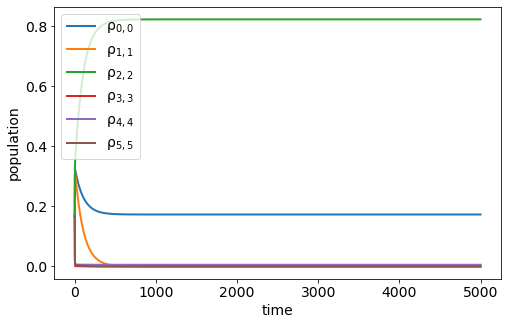

In [28]:
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [37]:
from sympy import diff

In [38]:
k = Symbol(u'k', real = True)

In [39]:
ham.transformed

Matrix([
[                         -B*gg - 1.0*Δ,                                      0,                                     0,                                      0,  0.166666666666666*Ω*(I*Coskz + Sinkz),                                     0],
[                                     0,                                 -1.0*Δ,                                     0, 0.166666666666666*Ω*(-I*Coskz + Sinkz),                                      0, 0.166666666666666*Ω*(I*Coskz + Sinkz)],
[                                     0,                                      0,                          B*gg - 1.0*Δ,                                      0, 0.166666666666666*Ω*(-I*Coskz + Sinkz),                                     0],
[                                     0,  0.166666666666666*Ω*(I*Coskz + Sinkz),                                     0,                                  -B*ge,                                      0,                                     0],
[0.166666666666666*Ω*(-I*Coskz 

In [42]:
DH = diff(ham.transformed,Coskz)*(-k*Sinkz) + diff(ham.transformed,Sinkz)*(k*Coskz)
DH

Matrix([
[                                                          0,                                                           0,                                                           0,                                                           0, 0.166666666666666*Coskz*k*Ω - 0.166666666666666*I*Sinkz*k*Ω,                                                           0],
[                                                          0,                                                           0,                                                           0, 0.166666666666666*Coskz*k*Ω + 0.166666666666666*I*Sinkz*k*Ω,                                                           0, 0.166666666666666*Coskz*k*Ω - 0.166666666666666*I*Sinkz*k*Ω],
[                                                          0,                                                           0,                                                           0,                                                           0, 0.16666666

In [43]:
Main.eval(f"""
            @everywhere begin
            DH = zeros(Num, {lx}, {ly})
            tmp = 0
            end
            """);


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(DH[idx-1,idy-1])
        hval = hval.replace('I','icomplex')
        print(hval)
        Main.eval(f"""
                @everywhere begin
                DH[{idx},{idy}] = {hval}
                tmp = 0
                end
                """);

0
0
0
0
0.166666666666666*Coskz*k*Ω - 0.166666666666666*icomplex*Sinkz*k*Ω
0
0
0
0
0.166666666666666*Coskz*k*Ω + 0.166666666666666*icomplex*Sinkz*k*Ω
0
0.166666666666666*Coskz*k*Ω - 0.166666666666666*icomplex*Sinkz*k*Ω
0
0
0
0
0.166666666666666*Coskz*k*Ω + 0.166666666666666*icomplex*Sinkz*k*Ω
0
0
0.166666666666666*Coskz*k*Ω - 0.166666666666666*icomplex*Sinkz*k*Ω
0
0
0
0
0.166666666666666*Coskz*k*Ω + 0.166666666666666*icomplex*Sinkz*k*Ω
0
0.166666666666666*Coskz*k*Ω - 0.166666666666666*icomplex*Sinkz*k*Ω
0
0
0
0
0.166666666666666*Coskz*k*Ω + 0.166666666666666*icomplex*Sinkz*k*Ω
0
0
0
0


In [46]:
# creating the parameter space to scan
varlist = np.linspace(0,4,5)
params = varlist

Main.params = params
Main.eval("@everywhere params = $params")

In [47]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Γ_val = 1
    Δgroup = -2.5*Γ_val
    Ω_val = 1.225*Γ_val
    pnew = ModelingToolkit.varmap_to_vars([
        B => 0,
        Δ => Δgroup,
        Ω => Ω_val,
        gg => 1,
        ge => 1,
        Γ => Γ_val,
        k => 1,
        v => params[i],
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [48]:
Main.eval("""
@everywhere function output_func(sol,i)
        return DH
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");
#            return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false


In [49]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

28.3213896

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)